In [59]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [60]:
import os
import shutil
target_dir = '/kaggle/working/potato_data'  # Create a target directory
potato_folders = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
# Assuming the PlantVillage dataset is in '/kaggle/input/plantvillage'
source_dir = '/kaggle/input/plantvillage-dataset/color'

for folder in potato_folders:
  source_folder = os.path.join(source_dir, folder)
  destination_folder = os.path.join(target_dir, folder)
  shutil.copytree(source_folder, destination_folder)

In [62]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("potato_data", shuffle=True, image_size = (256,256), batch_size =32)

Found 2152 files belonging to 3 classes.


In [63]:
classname = dataset.class_names
classname

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [64]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 2 1 0 0 0 0 1 0 0 1 0 2 0 0 0 1 1 1 1 2 2 0 0 1 2 0 1 1 1 1]


Visualize some of the images from our dataset

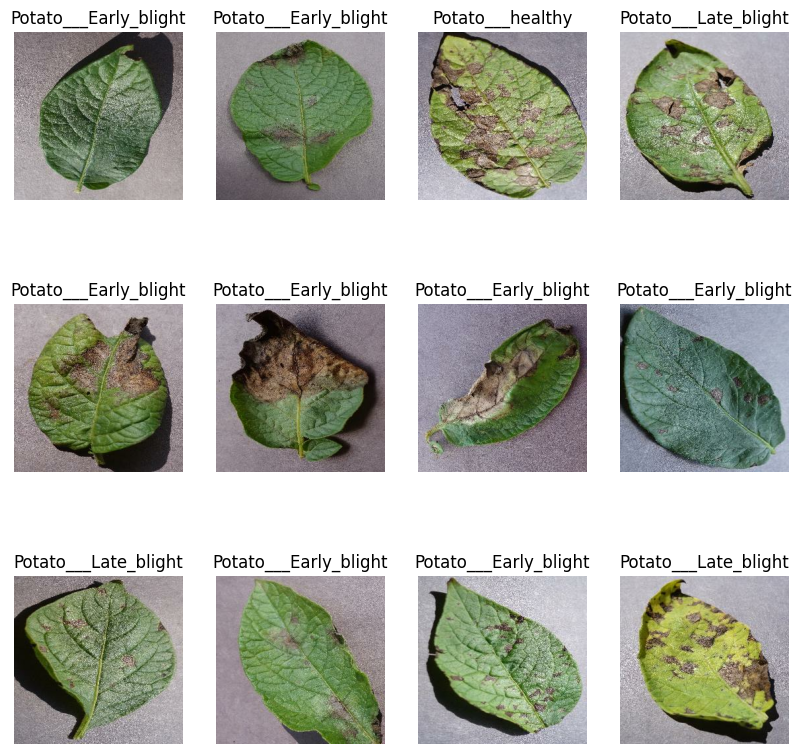

In [65]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classname[labels_batch[i]])
        plt.axis("off")

<b><h>split the dataset<h><b>

Training 
Validation
Testing

In [66]:
len(dataset)

68

In [67]:
def get_dataset_paratitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size=10000):
       # assert train_split + val_split + test_split == 1 if we want to check assertion error

        ds_size = len(ds)
        if shuffle:
           ds = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)
        test_size = int(train_split*ds_size)

        train_ds = ds.take(train_size) 
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds


In [68]:
train_ds, val_ds, test_ds = get_dataset_paratitions_tf(dataset)

Cache, Shuffle and Prefetch the dataset

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Data Resizing and Normalization

In [70]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(256, 256),
  tf.keras.layers.Rescaling(1.0 / 255)
])

Data Augmentation

In [71]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [72]:
train_ds = train_ds.map(
    lambda x, y : (data_augmentation(x,training = True),y)).prefetch(buffer_size = tf.data.AUTOTUNE)

Model Architecture

In [73]:
input_shape = (32, 256, 256, 3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(64, activation = 'relu'),

    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [74]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics = ['accuracy'])

In [76]:
history =model.fit(
    train_ds,
    epochs = 10,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 341ms/step - accuracy: 0.5238 - loss: 0.9166 - val_accuracy: 0.6198 - val_loss: 0.7985
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.7375 - loss: 0.6573 - val_accuracy: 0.6771 - val_loss: 0.5767
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 325ms/step - accuracy: 0.7956 - loss: 0.4578 - val_accuracy: 0.8073 - val_loss: 0.4961
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 323ms/step - accuracy: 0.8304 - loss: 0.4063 - val_accuracy: 0.8385 - val_loss: 0.3602
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.8868 - loss: 0.2925 - val_accuracy: 0.8802 - val_loss: 0.3191
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 328ms/step - accuracy: 0.8858 - loss: 0.2755 - val_accuracy: 0.8594 - val_loss: 0.3185
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 327ms/step - accuracy: 0.9089 - loss: 0.2097 - val_accuracy: 0.9323 - val_loss: 0.1951
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.9220 - loss: 0.1886 - val_accu

In [77]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9574 - loss: 0.1318


In [78]:
scores

[0.1058526411652565, 0.96484375]

In [79]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [80]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [81]:
type(history.history['loss'])

list

In [82]:
len(history.history['loss'])

10

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [84]:
acc

[0.5653935074806213,
 0.7667824029922485,
 0.8055555820465088,
 0.8570601940155029,
 0.8813657164573669,
 0.8975694179534912,
 0.9189814925193787,
 0.9172453880310059,
 0.9299768805503845,
 0.9467592835426331]

In [85]:
val_acc

[0.6197916865348816,
 0.6770833134651184,
 0.8072916865348816,
 0.8385416865348816,
 0.8802083134651184,
 0.859375,
 0.9322916865348816,
 0.9270833134651184,
 0.9427083134651184,
 0.9114583134651184]

Visualize Loss and Accuracy in Graph

Text(0.5, 1.0, 'Training & Validation Loss')

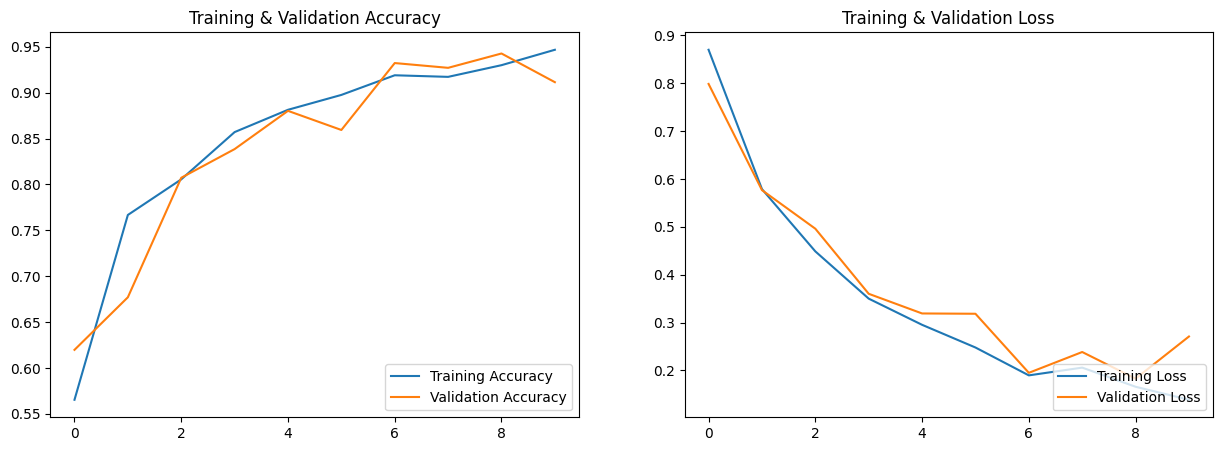

In [86]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(10), acc, label = "Training Accuracy")
plt.plot(range(10), val_acc, label = "Validation Accuracy")
plt.legend(loc= 'lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(10), loss, label = "Training Loss")
plt.plot(range(10), val_loss, label = "Validation Loss")
plt.legend(loc= 'lower right')
plt.title('Training & Validation Loss')

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
predicted label: Potato___Early_blight


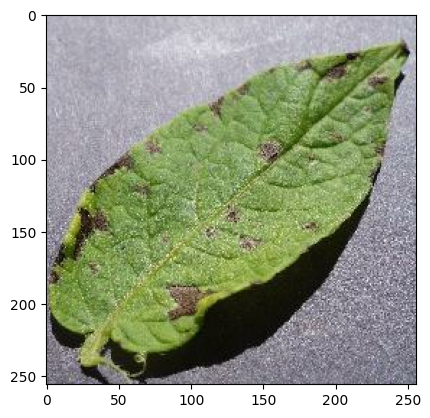

In [87]:
import numpy as np

for image_batch, labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = np.asarray(labels_batch[0])  # Convert to NumPy array

    print("first image to predict")
    plt.imshow(first_img)
    print('actual label:', classname[first_label])

    batch_prediction = model.predict(image_batch)
    print('predicted label:', classname[np.argmax(batch_prediction[0])])

In [88]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    predicted_class = classname[np.argmax(prediction[0])]
    confidence = round(100 * (np.argmax(prediction[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


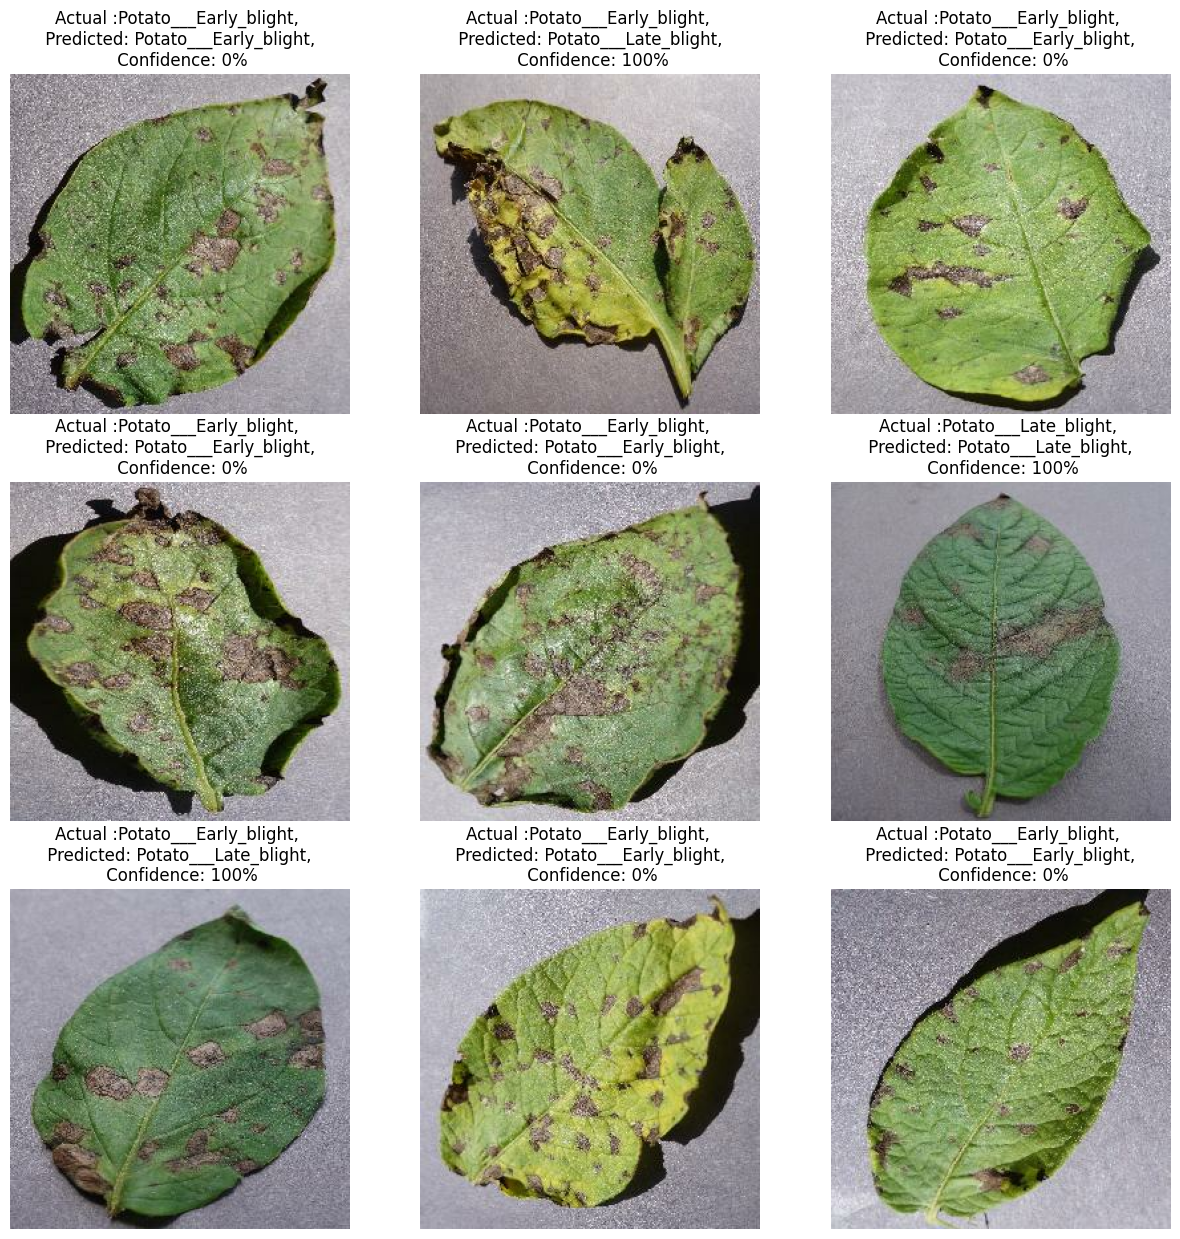

In [89]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i])
        actual_class = classname[labels[i]]
        plt.title(f"Actual :{actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

        plt.axis("off")

In [90]:
#homework : gradio, streamlit, flask

In [91]:
model.save('model.h5')